In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout ,GlobalAveragePooling2D,Input
from keras.models import Sequential,Model
from keras.preprocessing import image
from keras.src.legacy.preprocessing.image import ImageDataGenerator

## pre-trained model
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Evalution metrics
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_path = r"C:\Users\khang\Downloads\archive (8)\Vegetable Images\train"
test_path = r"C:\Users\khang\Downloads\archive (8)\Vegetable Images\test"
val_path = r"C:\Users\khang\Downloads\archive (8)\Vegetable Images\validation"

In [3]:
# extracting the different categories present in train dataset to plot 

image_categories = os.listdir( r"C:\Users\khang\Downloads\archive (8)\Vegetable Images\train")

print(image_categories)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


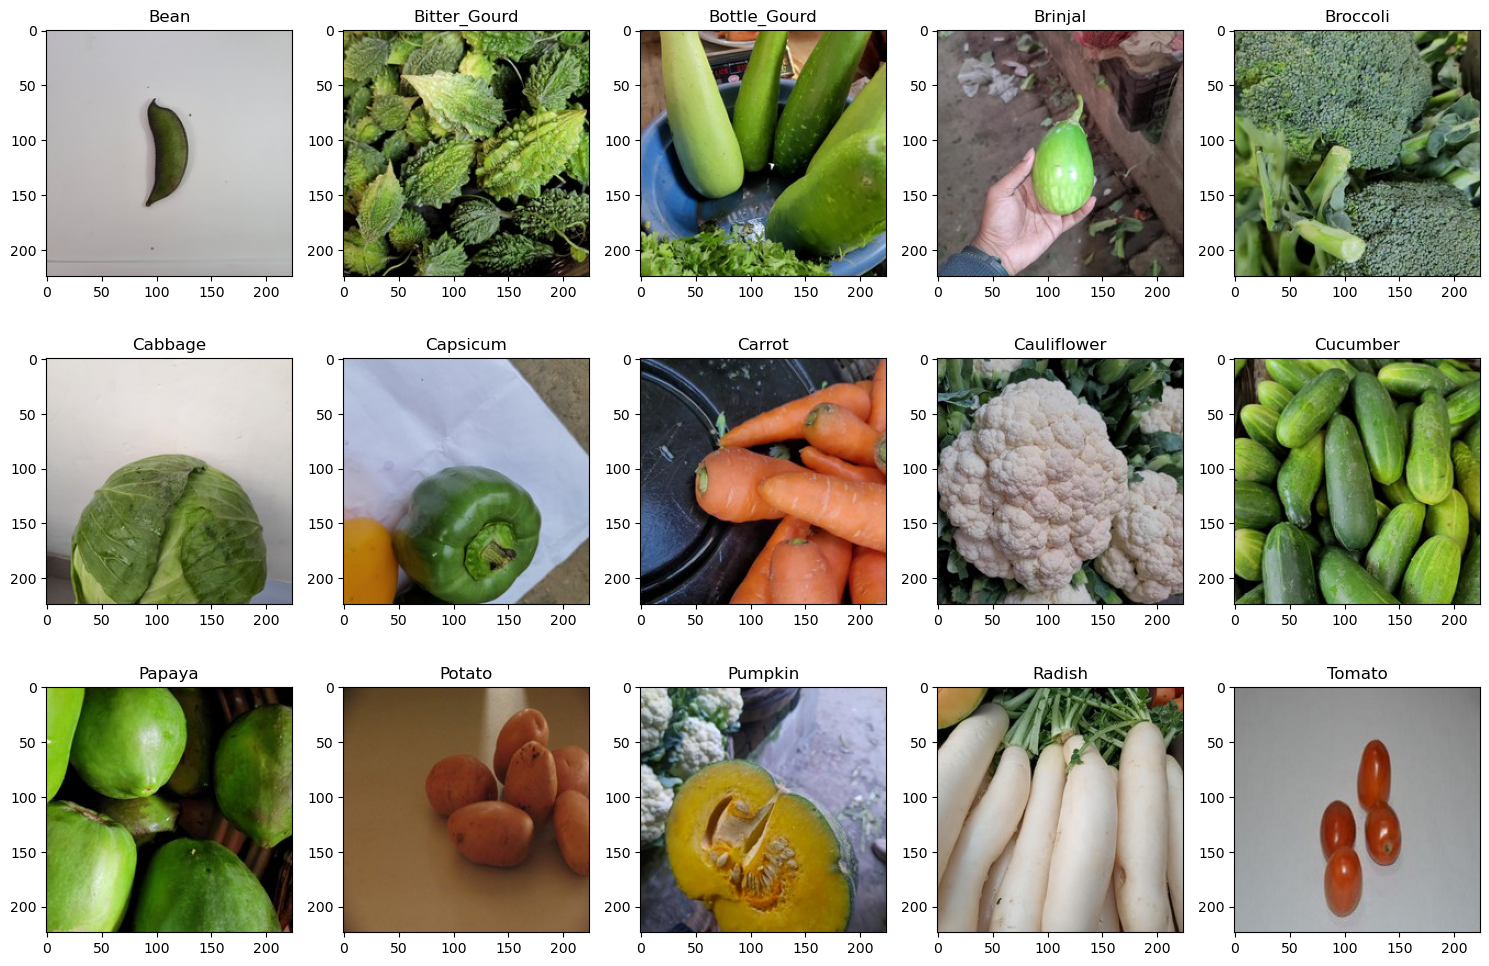

In [4]:
def plot_images(image_categories):
    
    
    plt.figure(1, figsize=(15, 10))
    for i, cat in enumerate(image_categories):
        
        
        image_path = train_path + '/' + cat
        images_in_folder = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255
        # Creating Subplot and plot the images
        plt.subplot(3, 5, i+1)
        plt.title(cat)
        plt.imshow(img_arr)
        
    plt.tight_layout()

plot_images(image_categories)

In [5]:
# checking if the dataset is balanced or imbalanced

def count_samples_per_category(dataset_path):
   
    categories = os.listdir(dataset_path)
    sample_counts = {}
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if os.path.isdir(category_path):
            num_samples = len(os.listdir(category_path))
            sample_counts[category] = num_samples
    return sample_counts

def is_balanced(dataset_path):
    
    sample_counts = count_samples_per_category(dataset_path)
    min_samples = min(sample_counts.values())
    max_samples = max(sample_counts.values())
    balance_threshold = 1.0
    if min_samples / max_samples >= balance_threshold:
        return True
    else:
        return False


dataset_path = r"C:\Users\khang\Downloads\archive (8)\Vegetable Images"

balanced = is_balanced(dataset_path)
if balanced:
    print("The dataset is balanced.")
else:
    print("The dataset is not balanced.")
    
# Counting the number of data points per category
category_counts = count_samples_per_category(dataset_path)

# Printing the number of data points per category
print("Number of data points per category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

# Calculating the total number of data points in the dataset
total_samples = sum(category_counts.values())

# Printing the total number of data points in the dataset
print("\nTotal number of data points in the dataset:", total_samples)


The dataset is balanced.
Number of data points per category:
test: 15
train: 15
validation: 15

Total number of data points in the dataset: 45


<AxesSubplot:>

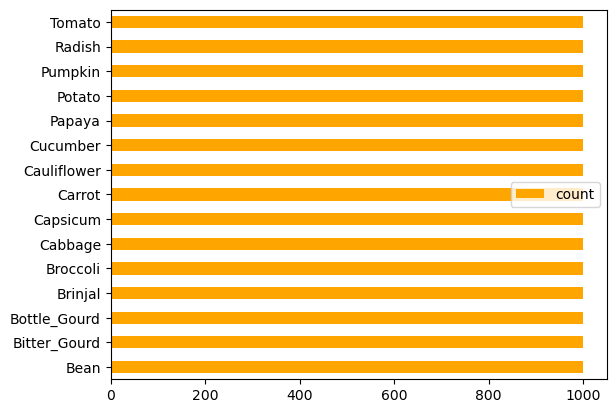

In [6]:
# plot

images_length={}
for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        images_length[cat]=len(images_in_folder)
        
pd.DataFrame(images_length,index = ['count']).T.plot(kind='barh',color='orange')

In [7]:
#  setting up data generators for training, validation, and testing

In [8]:
print("Train Data: ",end=' ')
train_gen = ImageDataGenerator(
                  rescale = 1./255,# Normalise the data
                  shear_range = 0.2,
                  zoom_range = 0.2,
                  horizontal_flip = True)

train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            )

print("Validation Data: ",end=' ')
val_gen = ImageDataGenerator(rescale=1./255) 
val_image_generator = val_gen.flow_from_directory(
                                            val_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            )
print("Test Data: ",end=' ')
test_gen = ImageDataGenerator(rescale=1./255)
test_image_generator = val_gen.flow_from_directory(
                                            val_path,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode='categorical',
                                            shuffle = False
                                )

Train Data:  Found 15000 images belonging to 15 classes.
Validation Data:  Found 3000 images belonging to 15 classes.
Test Data:  Found 3000 images belonging to 15 classes.


In [9]:
# converting class labels into interger classes by using "train_image_generator.class_indices" which is a dictionary
# provided by flow_from_directory method of imageGenerator class

In [10]:
class_map=dict([(v,k) for k,v in train_image_generator.class_indices.items()])

print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [11]:
# here we have got a dictionary of class labels converted into interger class

In [12]:
# model creation

In [13]:
input_layer = Input(shape=(224, 224, 3))

conv1 = Conv2D(64, kernel_size=(5, 5), activation='relu')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(32, kernel_size=(5, 5), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)


flatten = Flatten()(pool2)


dense1 = Dense(1024, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)


output_layer = Dense(15, activation='softmax')(dense2)


In [14]:
model_le= Model(inputs=input_layer, outputs=output_layer)

In [15]:

model_le.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 220, 220, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 89888)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      92,046,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,235,567 (351.85 MB)

 Trainable params: 92,235,567 (351.85 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import tensorflow.keras.callbacks as callbacks

early_stopping = callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Defining optimizer with learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_le.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

hist = model_le.fit(train_image_generator, epochs=30, verbose=1, 
                    validation_data=val_image_generator, 
                    steps_per_epoch=15000//64, 
                    validation_steps=3000//64, 
                    callbacks=[early_stopping]
                   )


Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 876s 4s/step - accuracy: 0.3895 - loss: 1.8557 - val_accuracy: 0.7198 - val_loss: 0.8444
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7344 - loss: 0.4578 - val_accuracy: 0.7679 - val_loss: 0.3885
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - accuracy: 0.7725 - loss: 0.7273 - val_accuracy: 0.8519 - val_loss: 0.4764
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8281 - loss: 0.2706 - val_accuracy: 0.8571 - val_loss: 0.2181
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 11718s 50s/step - accuracy: 0.8565 - loss: 0.4596 - val_accuracy: 0.8713 - val_loss: 0.4239
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9062 - loss: 0.1568 - val_accuracy: 0.8036 - val_loss: 0.2462
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 56538s 243s/step - accuracy: 0.9031 - loss: 0.3212 - val_accuracy: 0.9056 - val_loss: 0.3232


In [17]:
# plotring accuracy vs validation accuracy

In [18]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy',color='green')
    plt.plot(history.history['val_accuracy'],label='validation accuracy',color='black',linestyle='dashed')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

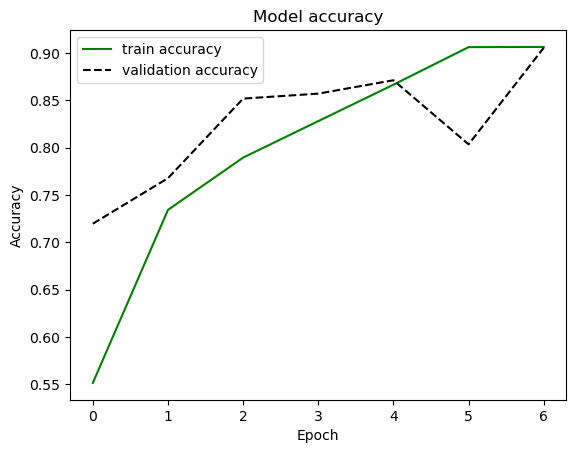

In [19]:
plot_accuracy(hist)

In [20]:
#  plotting loss vs validation loss

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss",color='red')
    plt.plot(history.history['val_loss'],label="validation loss",color='black',linestyle='dashed')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

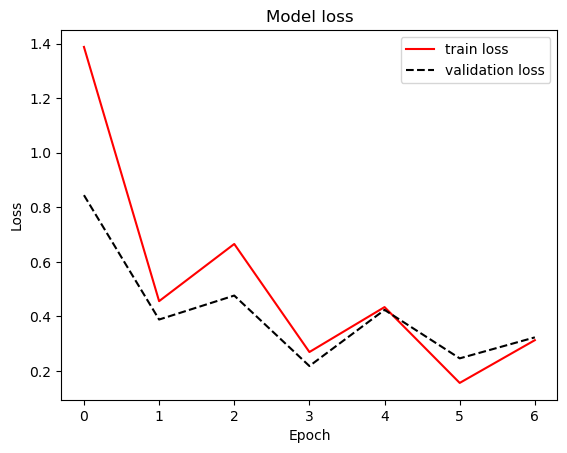

In [22]:
plot_loss(hist)

In [23]:
# Model Evaluation

In [24]:
def eval_(model):

    plt.figure(figsize=(20, 15))
    test_loss, test_acc =model.evaluate(test_image_generator)
    print(f'Model Test loss : {np.round(test_loss,2)} and Test Accuracy : {np.round(test_acc,2)} ')
    
    y_pred = model.predict(test_image_generator)
    predicted_classes = np.argmax(y_pred,axis=1)
    print("\n------- Classification Report -------\n",classification_report(test_image_generator.classes,predicted_classes))
    
    # Confusion Matrix dispaly
    ConfusionMatrixDisplay(confusion_matrix(test_image_generator.classes,predicted_classes),display_labels = test_image_generator.class_indices.keys()).plot()
    plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 657ms/step - accuracy: 0.8089 - loss: 0.6018
Model Test loss : 0.51 and Test Accuracy : 0.84 
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 683ms/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       200
           1       0.76      0.95      0.85       200
           2       0.94      0.74      0.83       200
           3       0.96      0.65      0.78       200
           4       0.91      0.83      0.87       200
           5       0.84      0.72      0.78       200
           6       0.93      0.95      0.94       200
           7       0.99      0.99      0.99       200
           8       0.72      0.79      0.75       200
           9       0.75      0.88      0.81       200
          10       0.86      0.88      0.87       200
          11       0.97      0.91      0.94       200
          12       0.93      0.78      0.85       200
          13       0.75      0.99   

<Figure size 2000x1500 with 0 Axes>

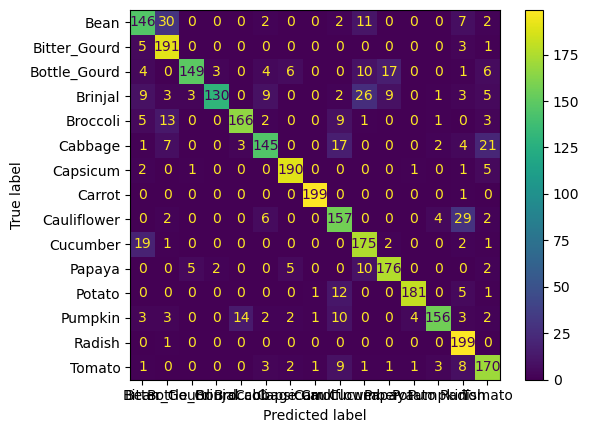

In [25]:
eval_(model_le)

In [26]:
# Applying Transfer learning on to the model

In [27]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=[224,224,3])

# Frezzing all the layers which prevents the weights being updated
for layer in base_model.layers:
    layer.trainable = False

## Add new layers to the Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(15, activation='softmax')(x)


model_V3 = Model(inputs=base_model.input, outputs=prediction)

early_stopping = keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',restore_best_weights=True,min_delta=0.1)

## compile the model
model_V3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

##fit the model
hist = model_V3.fit(train_image_generator, epochs=30, verbose=1, 
                    validation_data=val_image_generator, 
                    steps_per_epoch=15000//64, 
                    validation_steps=3000//64, 
                    callbacks=[early_stopping]
                   )

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 664s 3s/step - accuracy: 0.8173 - loss: 0.6076 - val_accuracy: 0.9823 - val_loss: 0.0516
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9219 - loss: 0.0999 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.9790 - loss: 0.0700 - val_accuracy: 0.9915 - val_loss: 0.0312
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9844 - loss: 0.0235 - val_accuracy: 0.9643 - val_loss: 0.0449


In [28]:
# plotting loss and accuracy after applying transfer learning

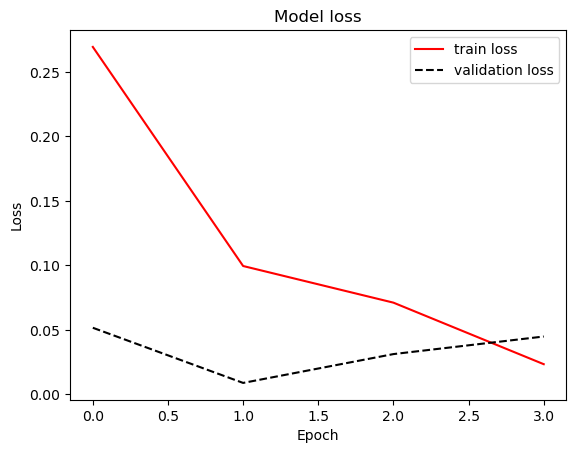

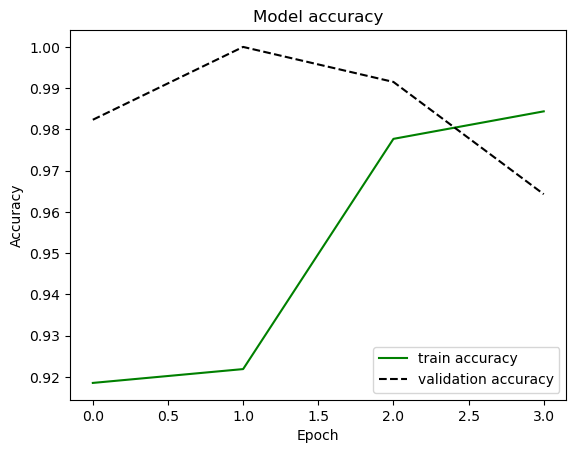

In [29]:
plot_loss(hist)
plot_accuracy(hist)

47/47 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9791 - loss: 0.0577
Model Test loss : 0.05 and Test Accuracy : 0.98 
47/47 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       1.00      1.00      1.00       200
           2       0.99      0.95      0.97       200
           3       0.96      0.93      0.94       200
           4       1.00      0.99      1.00       200
           5       1.00      1.00      1.00       200
           6       1.00      0.99      1.00       200
           7       1.00      1.00      1.00       200
           8       0.98      1.00      0.99       200
           9       0.95      0.97      0.96       200
          10       0.90      0.96      0.93       200
          11       0.99      0.99      0.99       200
          12       1.00      0.97      0.98       200
          13       0.99      0.99      0.9

<Figure size 2000x1500 with 0 Axes>

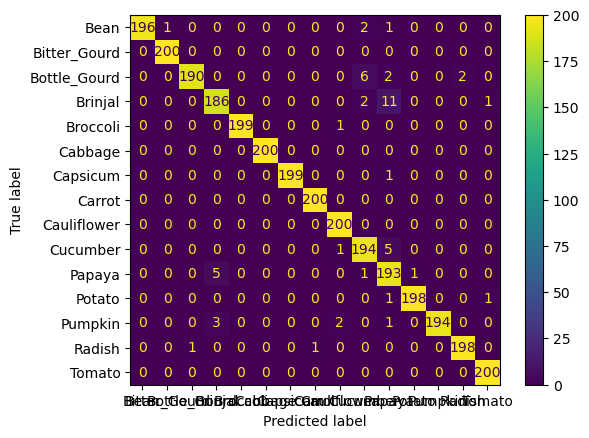

In [30]:
eval_(model_V3)


In [31]:
## Freezing only a Few layer

In [32]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))


# Frezzing all the layers which prevents the waits being updated
for layer in base_model.layers:
    layer.trainable = False
    
# unFrezzing last few layers 
for layer in base_model.layers[-10:]:
    layer.trainable = True

## Adding new layers to the Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(15, activation='softmax')(x)

In [33]:
model_v = Model(inputs=base_model.input, outputs=prediction)

In [34]:
early_stopping = keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',restore_best_weights=True) # Set up callbacks

## compile the model
model_v.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
##fit the model
hist = model_v.fit(train_image_generator, 
                 epochs=30, 
                 verbose=1, 
                 validation_data=val_image_generator, 
                 steps_per_epoch = 15000//64, 
                 validation_steps = 3000//64, 
                 callbacks=early_stopping,
                 )

Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 687s 3s/step - accuracy: 0.5572 - loss: 1.5734 - val_accuracy: 0.9569 - val_loss: 0.2175
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8438 - loss: 0.2882 - val_accuracy: 0.9464 - val_loss: 0.1092
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 1793s 8s/step - accuracy: 0.9313 - loss: 0.2673 - val_accuracy: 0.9776 - val_loss: 0.1146
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9375 - loss: 0.0938 - val_accuracy: 1.0000 - val_loss: 0.0387
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step - accuracy: 0.9591 - loss: 0.1541 - val_accuracy: 0.9847 - val_loss: 0.0753
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9688 - loss: 0.0813 - val_accuracy: 0.9821 - val_loss: 0.0295
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 2308s 10s/step - accuracy: 0.9740 - loss: 0.1027 - val_accuracy: 0.9888 - val_loss: 0.0569
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9844 - loss: 0.0410 - val_accu

In [36]:
# plotting loss and accuracy plots after freezing only few layers

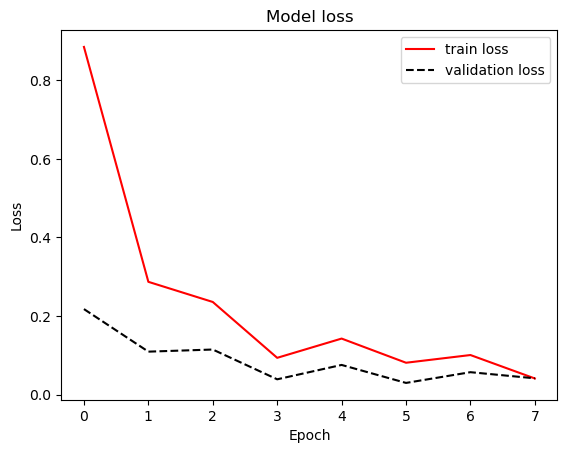

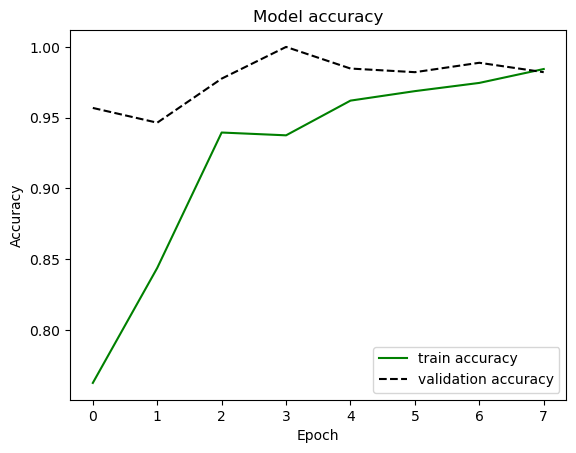

In [37]:
plot_loss(hist)
plot_accuracy(hist)

47/47 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.9852 - loss: 0.0749
Model Test loss : 0.07 and Test Accuracy : 0.98 
47/47 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step

------- Classification Report -------
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.99      0.98      0.98       200
           2       0.98      0.97      0.98       200
           3       0.98      0.95      0.97       200
           4       0.99      0.99      0.99       200
           5       1.00      1.00      1.00       200
           6       0.99      0.99      0.99       200
           7       0.99      0.99      0.99       200
           8       0.99      1.00      1.00       200
           9       0.98      0.94      0.96       200
          10       0.93      0.97      0.95       200
          11       0.98      0.99      0.99       200
          12       1.00      0.98      0.99       200
          13       0.99      0.99      0

<Figure size 2000x1500 with 0 Axes>

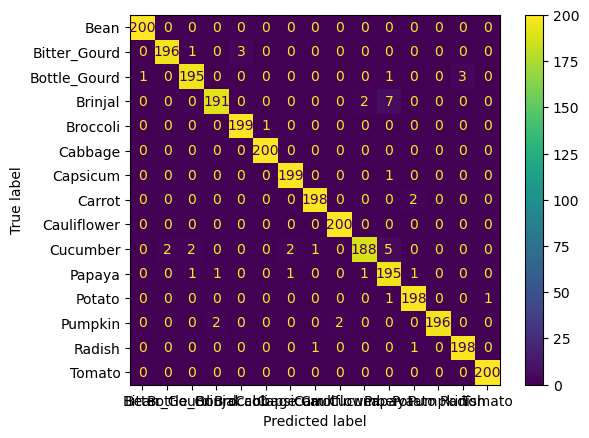

In [38]:
eval_(model_v)

In [39]:
# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


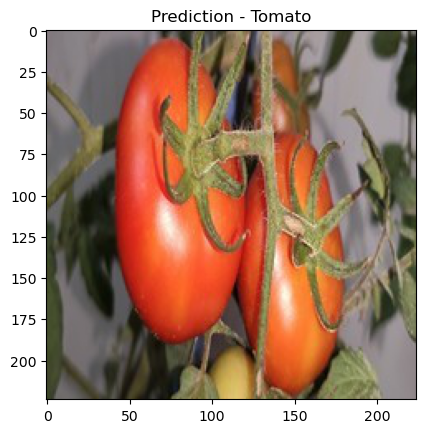

In [41]:
def predict(label,image_number):

    if label not in class_map.values() or image_number >=1000:
        print('Wrong Input 1. check if label in those 15 classes 2. image_number must be less than 1000')
    image_path = train_path + '/' + label
    images_in_folder = os.listdir(image_path)
    first_image_of_folder = images_in_folder[image_number]
    image_path += '/'+first_image_of_folder
    
    img_ = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model_v.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(class_map[index]))
    plt.imshow(img_array)
    

predict('Tomato',179)  